In [27]:
import os, re, zipfile, gc, warnings
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [28]:
DATA_DIR = "/content"
files = os.listdir(DATA_DIR)
def find_file(p):
    return next((os.path.join(DATA_DIR,f) for f in files if re.search(p,f,re.I)), None)

# events.csv.zip
events_zip = find_file(r'events.*\.csv\.zip')
with zipfile.ZipFile(events_zip,'r') as z:
    fname = [f for f in z.namelist() if f.endswith('.csv')][0]
    z.extract(fname, DATA_DIR)
events = pd.read_csv(os.path.join(DATA_DIR,fname), low_memory=False)
print("Events:", events.shape)

#  item_properties parts
def read_props(path): return pd.read_csv(path, compression='zip', low_memory=False)
ip1_path = find_file(r'item_properties_part1.*\.csv\.zip')
ip2_path = find_file(r'item_properties_part2.*\.csv\.zip')

ip1 = read_props(ip1_path) if ip1_path else pd.DataFrame()
ip2 = read_props(ip2_path) if ip2_path else pd.DataFrame()

if not ip1.empty or not ip2.empty:
    item_props = pd.concat([ip1, ip2], ignore_index=True)
    print("Item properties:", item_props.shape)
else:
    print("No item properties files found.")
    item_props = pd.DataFrame()


#  category_tree (optional)
cat_path = find_file(r'category_tree.*\.csv')
if cat_path:
    category_tree = pd.read_csv(cat_path)
    print("Category tree:", category_tree.shape)

Events: (2756101, 5)
Item properties: (20275902, 4)


In [29]:
DATA_DIR = "/content"
SAMPLE_EVENTS_FRAC = 0.50
MAX_ITEMPROP_ROWS = 1200000
TFIDF_MAX_FEATURES = 8000
TFIDF_MAX_ITEMS = 6000
K_CLUSTERS = 4
RANDOM_STATE = 42

In [30]:
def find_file(pattern):
    for f in os.listdir(DATA_DIR):
        if re.search(pattern, f, flags=re.I):
            return os.path.join(DATA_DIR, f)
    return None

def detect_timestamp_unit(series):
    sample = series.dropna().astype(float)
    if sample.empty: return None
    m = sample.median()
    if m > 1e14: return 'us'
    if m > 1e11: return 'ms'
    return 's'

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    low = s.quantile(lower_q); high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

def data_quality_report(df, name="df", head=3):
    print(f"\n-- DATA QUALITY REPORT: {name} --")
    print("shape:", df.shape)
    print("missing values (top):")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    print("duplicates:", df.duplicated().sum())
    display(df.head(head))
    print("-- end report --\n")


In [31]:
#  Load events
events_zip = find_file(r'events.*\.csv.*zip')
with zipfile.ZipFile(events_zip, 'r') as z:
    csv_name = [n for n in z.namelist() if n.endswith('.csv')][0]
    z.extract(csv_name, DATA_DIR)
events = pd.read_csv(os.path.join(DATA_DIR, csv_name), low_memory=False)
if SAMPLE_EVENTS_FRAC:
    events = events.sample(frac=SAMPLE_EVENTS_FRAC, random_state=RANDOM_STATE)
print("Events loaded:", events.shape)
data_quality_report(events, "events (raw)")

#  Load item_properties
def read_props_zip(path, nrows=None):
    if not path: return pd.DataFrame()
    with zipfile.ZipFile(path,'r') as z:
        csvs = [f for f in z.namelist() if f.endswith('.csv')]
        with z.open(csvs[0]) as f:
            return pd.read_csv(f, nrows=nrows, low_memory=False)

ip1 = read_props_zip(find_file(r'item_properties_part1.*\.csv.*zip'), nrows=MAX_ITEMPROP_ROWS)
ip2 = read_props_zip(find_file(r'item_properties_part2.*\.csv.*zip'), nrows=MAX_ITEMPROP_ROWS)
item_props = pd.concat([ip1, ip2], ignore_index=True)
print("Item props loaded:", item_props.shape)
data_quality_report(item_props, "item_props (raw)")


Events loaded: (1378050, 5)

-- DATA QUALITY REPORT: events (raw) --
shape: (1378050, 5)
missing values (top):
transactionid    1366800
timestamp              0
visitorid              0
event                  0
itemid                 0
dtype: int64
duplicates: 103


,timestamp,visitorid,event,itemid,transactionid
486798,1435193216976,50734,view,4442,NaN
1145255,1440996903983,355903,view,269631,NaN
1601366,1431280237515,1066758,view,221329,NaN


-- end report --

Item props loaded: (2400000, 4)

-- DATA QUALITY REPORT: item_props (raw) --
shape: (2400000, 4)
missing values (top):
timestamp    0
itemid       0
property     0
value        0
dtype: int64
duplicates: 0


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


-- end report --



In [32]:
#  Detect column names
def guess_col(cols, candidates):
    for c in candidates:
        for col in cols:
            if c.lower() == col.lower(): return col
    for c in candidates:
        for col in cols:
            if c.lower() in col.lower(): return col
    return None

cust_col = guess_col(events.columns, ['visitorid','user_id','userid','customerid'])
item_col = guess_col(events.columns, ['itemid','productid'])
time_col = guess_col(events.columns, ['timestamp','ts','time'])
event_col = guess_col(events.columns, ['event','event_type','action'])
price_col = guess_col(events.columns, ['price','amount','unitprice'])
print("Detected:", cust_col, item_col, time_col, event_col, price_col)

#  Cleaning
events = events.drop_duplicates()
events[cust_col] = pd.to_numeric(events[cust_col], errors='coerce')
events[item_col] = pd.to_numeric(events[item_col], errors='coerce')
events = events.dropna(subset=[cust_col,item_col])
events = events[(events[cust_col]>0)&(events[item_col]>0)]

# timestamp parse
unit = detect_timestamp_unit(events[time_col]) or 's'
events[time_col] = pd.to_datetime(events[time_col], unit=unit, errors='coerce')
events = events.dropna(subset=[time_col])
events[event_col] = events[event_col].astype(str).str.lower().str.strip()
events = events[events[event_col].isin(['view','addtocart','transaction','purchase'])]
data_quality_report(events, "events (cleaned)")


Detected: visitorid itemid timestamp event None

-- DATA QUALITY REPORT: events (cleaned) --
shape: (1377945, 5)
missing values (top):
transactionid    1366695
timestamp              0
visitorid              0
event                  0
itemid                 0
dtype: int64
duplicates: 0


,timestamp,visitorid,event,itemid,transactionid
486798,2015-06-25 00:46:56.976,50734,view,4442,NaN
1145255,2015-08-31 04:55:03.983,355903,view,269631,NaN
1601366,2015-05-10 17:50:37.515,1066758,view,221329,NaN


-- end report --



In [33]:
# Build transactions
purchase_events = events[events[event_col].isin(['transaction','purchase'])]
if len(purchase_events) > 0:
    transactions = purchase_events[[cust_col,item_col,time_col]]
else:
    transactions = (events.groupby([cust_col,item_col])
                    .agg(last_time=(time_col,'max'),
                         interaction_count=(event_col,'count'))
                    .reset_index())
transactions = transactions.rename(columns={cust_col:'customer_id',item_col:'item_id'})
data_quality_report(transactions,"transactions")

# RFM
snapshot = (transactions['last_time'].max()
            + timedelta(days=1) if 'last_time' in transactions else pd.Timestamp.now())
if 'interaction_count' in transactions:
    rfm = (transactions.groupby('customer_id')
           .agg(Recency=('last_time',lambda x:(snapshot-x.max()).days),
                Frequency=('item_id','nunique'),
                Monetary=('interaction_count','sum'))
           .reset_index())
else:
    rfm = (transactions.groupby('customer_id')
           .agg(Recency=(time_col,lambda x:(snapshot-x.max()).days),
                Frequency=('item_id','nunique'),
                Monetary=('item_id','count'))
           .reset_index())

for c in ['Recency','Frequency','Monetary']:
    rfm[c] = winsorize_series(rfm[c]).fillna(0)
    rfm[c] = np.log1p(rfm[c])
rfm['Recency'] = rfm['Recency'].clip(lower=0)
data_quality_report(rfm,"RFM features")



-- DATA QUALITY REPORT: transactions --
shape: (11250, 3)
missing values (top):
customer_id    0
item_id        0
timestamp      0
dtype: int64
duplicates: 0


,customer_id,item_id,timestamp
432583,765630,394809,2015-06-22 21:39:07.553
1797805,937463,260426,2015-05-19 19:58:02.065
1241274,512033,276821,2015-09-05 23:02:09.731


-- end report --


-- DATA QUALITY REPORT: RFM features --
shape: (6774, 4)
missing values (top):
customer_id    0
Recency        0
Frequency      0
Monetary       0
dtype: int64
duplicates: 0


,customer_id,Recency,Frequency,Monetary
0,172,8.228444,1.098612,1.098612
1,186,8.228978,0.693147,0.693147
2,264,8.222016,0.693147,0.693147


-- end report --



Cluster counts:
 cluster
1    2922
3    2885
0     794
2     173
Name: count, dtype: int64


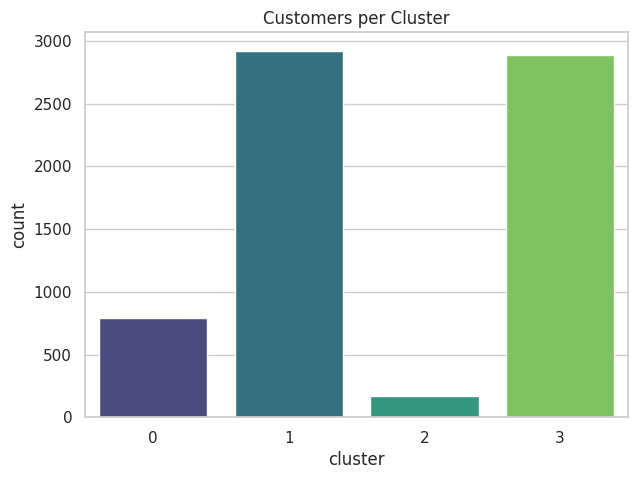

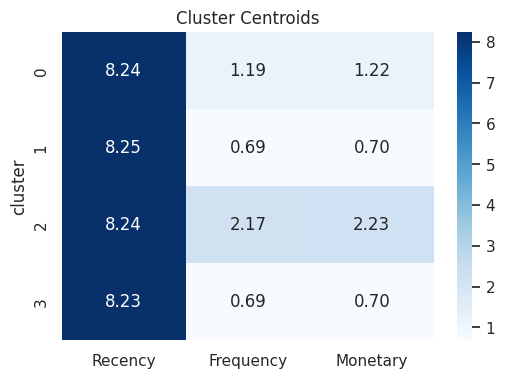

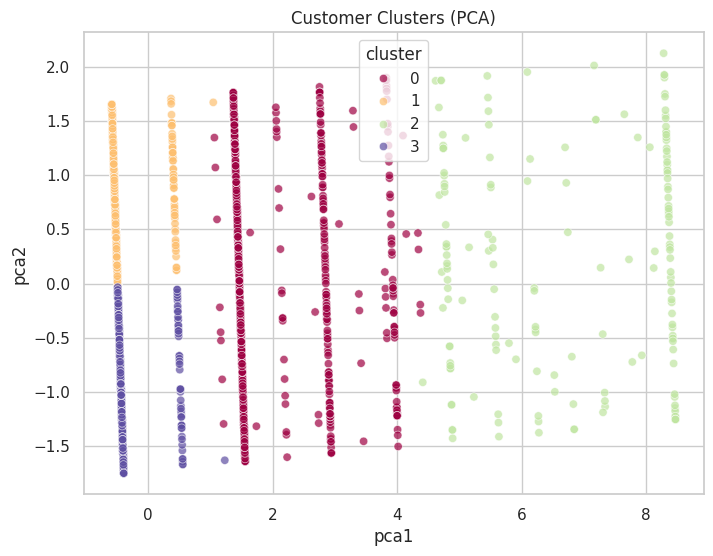

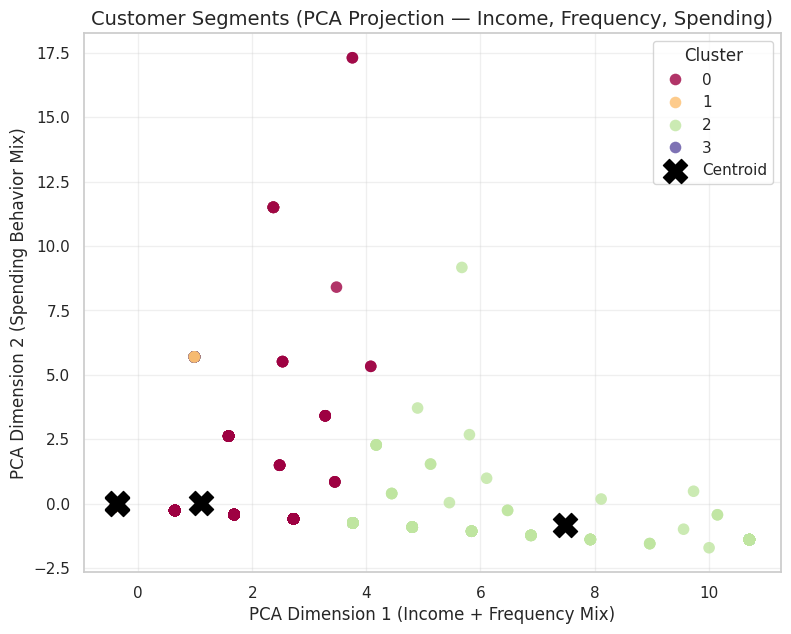

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])
km = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_STATE, n_init=20)
rfm['cluster'] = km.fit_predict(X)
print("Cluster counts:\n", rfm['cluster'].value_counts())

#  Visualizations
plt.figure(figsize=(7,5))
sns.countplot(x='cluster', data=rfm, palette='viridis')
plt.title("Customers per Cluster"); plt.show()

rfm_means = rfm.groupby('cluster')[['Recency','Frequency','Monetary']].mean()
plt.figure(figsize=(6,4))
sns.heatmap(rfm_means, annot=True, cmap='Blues', fmt=".2f")
plt.title("Cluster Centroids"); plt.show()

pca = PCA(n_components=2, random_state=RANDOM_STATE)
rfm_pca = pca.fit_transform(X)
rfm['pca1'],rfm['pca2']=rfm_pca[:,0],rfm_pca[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(x='pca1',y='pca2',hue='cluster',data=rfm,palette='Spectral',alpha=0.7)
plt.title("Customer Clusters (PCA)"); plt.show()


rfm['Income'] = np.expm1(rfm['Monetary'])
rfm['PurchaseFrequency'] = np.expm1(rfm['Frequency'])
rfm['AvgSpending'] = rfm['Income'] / rfm['PurchaseFrequency']
rfm.replace([np.inf,-np.inf], np.nan, inplace=True)
rfm.fillna(0, inplace=True)
# Customer Segments Visualization

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
features = ['Income', 'PurchaseFrequency', 'AvgSpending'] # Changed to use Income and PurchaseFrequency
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm[features]) # Changed to use rfm DataFrame
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled)
rfm['pca1_income_freq_spending'] = pca_result[:, 0] # Added new PCA columns to avoid overwriting
rfm['pca2_income_freq_spending'] = pca_result[:, 1]

# Compute centroids
centroids = rfm.groupby('cluster')[['pca1_income_freq_spending','pca2_income_freq_spending']].mean().reset_index() # Changed to use new PCA columns

# Plot clusters
plt.figure(figsize=(9,7))
sns.scatterplot(
    x='pca1_income_freq_spending', # Changed to use new PCA columns
    y='pca2_income_freq_spending', # Changed to use new PCA columns
    hue='cluster',
    data=rfm,
    palette='Spectral',
    s=70,
    alpha=0.8,
    edgecolor='none'
)

# Mark centroids
plt.scatter(
    centroids['pca1_income_freq_spending'], # Changed to use new PCA columns
    centroids['pca2_income_freq_spending'], # Changed to use new PCA columns
    s=300,
    color='black',
    marker='X',
    label='Centroid'
)

plt.title("Customer Segments (PCA Projection — Income, Frequency, Spending)", fontsize=14)
plt.xlabel("PCA Dimension 1 (Income + Frequency Mix)")
plt.ylabel("PCA Dimension 2 (Spending Behavior Mix)")
plt.legend(title='Cluster', loc='best')
plt.grid(True, alpha=0.3)
plt.show()


Customer Segment Summary:


,cluster,Average Income,Average Spending,Average Frequency
0,0,2.44,1.06,2.34
1,1,1.02,1.02,1.00
2,2,8.77,1.07,8.24
3,3,1.02,1.02,1.00


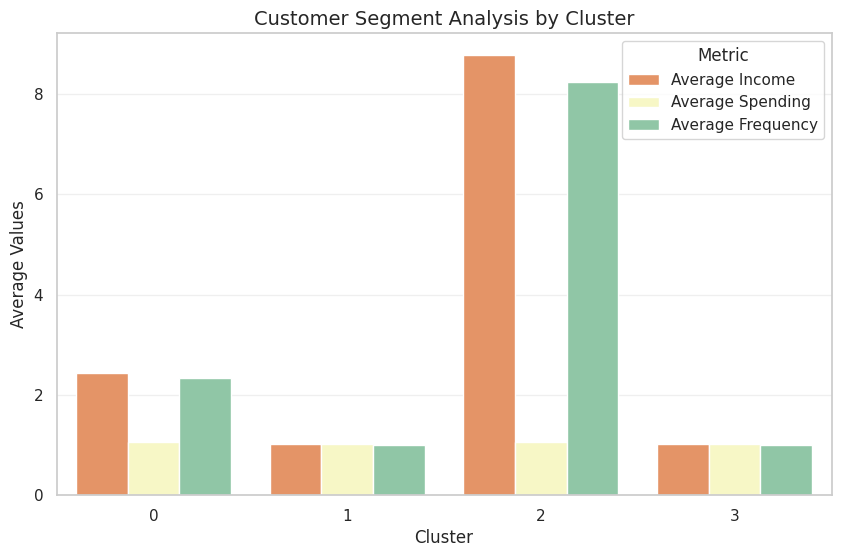

In [35]:
# Customer Segment Analysis - Bar Chart
# Compute average metrics per cluster
# Merge cluster information from rfm into transactions
# transactions_with_cluster = pd.merge(transactions, rfm[['customer_id', 'cluster']], on='customer_id', how='left') # Removed as we will use rfm directly

segment_summary = (
    rfm.groupby('cluster')[['Income','AvgSpending','PurchaseFrequency']]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={
        'Income': 'Average Income', # Renamed TotalIncome to Income
        'AvgSpending': 'Average Spending',
        'PurchaseFrequency': 'Average Frequency'
    })
)

print("\nCustomer Segment Summary:")
display(segment_summary)


segment_melted = segment_summary.melt(
    id_vars='cluster',
    value_vars=['Average Income', 'Average Spending', 'Average Frequency'], # Updated value_vars
    var_name='Metric',
    value_name='Value'
)

# Plot grouped bar chart
plt.figure(figsize=(10,6))
sns.barplot(
    x='cluster',
    y='Value',
    hue='Metric',
    data=segment_melted,
    palette='Spectral'
)

plt.title("Customer Segment Analysis by Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Average Values") # Updated ylabel
plt.legend(title='Metric')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [36]:
#  Prepare text
if not item_props.empty and {'itemid','value'}.issubset(item_props.columns):
    item_props = item_props.dropna(subset=['itemid','value']).drop_duplicates(['itemid','value'])
    if item_props['itemid'].nunique() > TFIDF_MAX_ITEMS:
        keep_ids = item_props['itemid'].value_counts().index[:TFIDF_MAX_ITEMS]
        item_props = item_props[item_props['itemid'].isin(keep_ids)]
    text_df = (item_props.groupby('itemid')['value']
               .apply(lambda s:' '.join(s.unique())).reset_index().rename(columns={'value':'text'}))
else:
    text_df = pd.DataFrame()
print("Text DF shape:", text_df.shape)

#  TF-IDF
if not text_df.empty:
    tfidf = TfidfVectorizer(stop_words='english', max_df=0.8, max_features=TFIDF_MAX_FEATURES)
    tfidf_matrix = tfidf.fit_transform(text_df['text'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    idx_to_item = {i:text_df.iloc[i]['itemid'] for i in range(len(text_df))}
    item_to_idx = {v:k for k,v in idx_to_item.items()}

    def top_similar_items(item_id, topn=5):
        if item_id not in item_to_idx: return []
        idx = item_to_idx[item_id]
        sims = sorted(list(enumerate(cosine_sim[idx])), key=lambda x:x[1], reverse=True)[1:topn+1]
        return [(idx_to_item[i], float(s)) for i,s in sims]

    sample_item = list(item_to_idx.keys())[0]
    print("Sample similar items:", top_similar_items(sample_item,5))
else:
    print("No product text for TF-IDF.")


Text DF shape: (6000, 2)
Sample similar items: [(np.int64(294517), 0.6375957629763147), (np.int64(138765), 0.6137230519774409), (np.int64(11374), 0.5991526512757517), (np.int64(234735), 0.5942100737862284), (np.int64(350227), 0.5867897272180671)]


In [38]:
rfm.to_csv(os.path.join(DATA_DIR,"customers_rfm_clusters.csv"), index=False)
if not text_df.empty:
    text_df.to_csv(os.path.join(DATA_DIR,"products_text.csv"), index=False)
print("Saved cleaned outputs to /content")

if not rfm.empty:
    sample_customer = rfm['customer_id'].sample(1, random_state=RANDOM_STATE).iloc[0]
    print("Sample customer:", sample_customer,
          "→ cluster:", rfm.loc[rfm['customer_id']==sample_customer,'cluster'].iloc[0])


Saved cleaned outputs to /content
Sample customer: 521833 → cluster: 1


In [39]:
# Inspect all main variables to avoid duplicates
vars_defined = [v for v in globals() if not v.startswith("_")]
print(" Variables in notebook:", vars_defined)

# Quick check for key datasets
for v in ["events", "item_properties_part1", "item_properties_part2", "user_item", "customer_summary"]:
    if v in globals():
        df = eval(v)
        if isinstance(df, pd.DataFrame):
            print(f"\n {v}: shape={df.shape}, columns={list(df.columns)[:6]}")


 Variables in notebook: ['In', 'Out', 'get_ipython', 'exit', 'quit', 'os', 're', 'zipfile', 'gc', 'warnings', 'pd', 'np', 'timedelta', 'StandardScaler', 'KMeans', 'PCA', 'TfidfVectorizer', 'linear_kernel', 'plt', 'sns', 'DATA_DIR', 'files', 'find_file', 'events_zip', 'z', 'fname', 'events', 'read_props', 'ip1_path', 'ip2_path', 'ip1', 'ip2', 'item_props', 'cat_path', 'SAMPLE_EVENTS_FRAC', 'MAX_ITEMPROP_ROWS', 'TFIDF_MAX_FEATURES', 'TFIDF_MAX_ITEMS', 'K_CLUSTERS', 'RANDOM_STATE', 'detect_timestamp_unit', 'winsorize_series', 'data_quality_report', 'csv_name', 'read_props_zip', 'guess_col', 'cust_col', 'item_col', 'time_col', 'event_col', 'price_col', 'unit', 'purchase_events', 'transactions', 'snapshot', 'rfm', 'c', 'scaler', 'X', 'km', 'rfm_means', 'pca', 'rfm_pca', 'features', 'scaled', 'pca_result', 'centroids', 'segment_summary', 'segment_melted', 'keep_ids', 'text_df', 'tfidf', 'tfidf_matrix', 'cosine_sim', 'idx_to_item', 'item_to_idx', 'top_similar_items', 'sample_item', 'sample_cu

In [40]:

#  MEMORY-SAFE USER–ITEM MATRIX
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

print("STEP 1: Building memory-safe user–item matrix...")

user_col = "user_id" if "user_id" in events.columns else events.columns[0]
item_col = "item_id" if "item_id" in events.columns else events.columns[1]

# Convert to numeric category codes
events["_u"] = events[user_col].astype("category").cat.codes
events["_i"] = events[item_col].astype("category").cat.codes

rows = events["_u"].values
cols = events["_i"].values
data = np.ones(len(events), dtype=np.int8)

# Sparse matrix
user_item_sparse = csr_matrix((data, (rows, cols)))

print(" user_item_sparse created:", user_item_sparse.shape)


STEP 1: Building memory-safe user–item matrix...
 user_item_sparse created: (1376589, 841338)


In [41]:
# CUSTOMER SUMMARY

print("\nSTEP 2: Building customer_summary...")

customer_ids = events[user_col].astype("category").cat.categories

customer_summary = pd.DataFrame({
    "customer_id": customer_ids,
    "total_purchases": np.array(user_item_sparse.sum(axis=1)).ravel(),
    "unique_items": np.array((user_item_sparse > 0).sum(axis=1)).ravel()
})

print(" customer_summary ready:", customer_summary.shape)



STEP 2: Building customer_summary...
 customer_summary ready: (1376589, 3)


In [42]:
# MEMORY-SAFE CLUSTERING

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

print("\nSTEP 3:  KMeans...")

# Sample only
sample_n = min(5000, len(customer_summary))
sample_df = customer_summary.sample(sample_n, random_state=42)

features = ["total_purchases", "unique_items"]

scaler = StandardScaler()
X_sample = scaler.fit_transform(sample_df[features])

kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans.fit(X_sample)

# Assign clusters for all users
X_full = scaler.transform(customer_summary[features])
clusters, _ = pairwise_distances_argmin_min(X_full, kmeans.cluster_centers_)

customer_summary["cluster"] = clusters

print(" Clustering completed ")



STEP 3:  KMeans...
 Clustering completed 


In [43]:
# STEP 4: PRODUCT TEXT
print("\nSTEP 4: Preparing product text features")

if "item_props" in globals() and not item_props.empty:
    item_df = item_props.copy()
elif "item_properties_part1" in globals() and not item_properties_part1.empty:
    item_df = item_properties_part1.copy()
elif "item_properties_part2" in globals() and not item_properties_part2.empty:
    item_df = item_properties_part2.copy()
else:
    raise Exception("item_properties dataset missing.")

# Pick only 2 text columns to save memory
# Ensure 'itemid' is not treated as a text column for combination if it exists
text_cols = [c for c in item_df.columns if item_df[c].dtype == object and c != 'itemid'][:2]

if text_cols:
    item_df["text_combined"] = (
        item_df[text_cols]
        .fillna("")
        .apply(lambda x: " ".join(x.values.astype(str)), axis=1)
    )
else:
    item_df["text_combined"] = ""

print(" text_combined created ")



STEP 4: Preparing product text features
 text_combined created 


In [44]:

# STEP 4: AUTO-DETECT & PREPARE ITEM PROPERTIES


print("\nSTEP 4: Auto-detecting product properties dataset...")

item_df = None

#  Check common variable names
possible_names = [
    "item_properties",
    "item_props",
    "items",
    "products",
    "product_df",
    "item_properties_part1",
    "item_properties_part2"
]

for name in possible_names:
    if name in globals():
        df = globals()[name]
        # validate if likely item properties dataset
        if isinstance(df, pd.DataFrame) and df.shape[1] >= 3:
            item_df = df.copy()
            print(f" Auto-detected item properties as '{name}'")
            break

# 2️ Auto-detect ANY DataFrame with:
#     → item_id column
#     → OR many text columns
#     → OR many NaNs (typical metadata)
if item_df is None:
    for varname, df in globals().items():
        if isinstance(df, pd.DataFrame):
            if "item_id" in df.columns:
                item_df = df.copy()
                print(f" Found dataset containing item_id → '{varname}'")
                break

if item_df is None:
    for varname, df in globals().items():
        if isinstance(df, pd.DataFrame):
            # heuristic: metadata tables often have many object columns
            text_cols = [c for c in df.columns if df[c].dtype == object]
            if len(text_cols) >= 2:
                item_df = df.copy()
                print(f" Using '{varname}' as item_df (matches metadata pattern)")
                break

# If still missing → show all DataFrames for debugging
if item_df is None:
    print(" Could not auto-detect item properties.")
    print("Available DataFrames:")
    for varname, df in globals().items():
        if isinstance(df, pd.DataFrame):
            print(" •", varname, df.shape)
    raise Exception(" No item properties dataset found.")
# Prepare text columns

print(" item_df successfully detected:", item_df.shape)

# pick max 2 text columns only (avoid RAM crash)
text_cols = [c for c in item_df.columns if item_df[c].dtype == object][:2]

if len(text_cols) == 0:
    print("⚠ No text columns detected — creating placeholder text column.")
    item_df["text_combined"] = ""
else:
    item_df["text_combined"] = (
        item_df[text_cols]
        .fillna("")
        .apply(lambda x: " ".join(x.values.astype(str)), axis=1)
    )

print("text_combined column created safely using:", text_cols)



STEP 4: Auto-detecting product properties dataset...
 Auto-detected item properties as 'item_props'
 item_df successfully detected: (71218, 4)
text_combined column created safely using: ['property', 'value']


In [45]:

# STEP 5: ULTRA MEMORY-SAFE RECOMMENDER MODE

print("\nSTEP 5: Building ultra memory-safe recommenders...")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Content-Based Recommender

class ContentBased:
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.vec = TfidfVectorizer(max_features=2000, stop_words="english")
        self.mat = self.vec.fit_transform(self.df["text_combined"])

    def recommend(self, item_id, k=10):
        if "item_id" not in self.df:
            return []

        idx = self.df.index[self.df["item_id"] == item_id]
        if len(idx) == 0:
            return []

        idx = idx[0]
        sims = cosine_similarity(self.mat[idx], self.mat).flatten()

        top = sims.argsort()[::-1][1:k+1]
        return list(self.df.iloc[top]["item_id"])



# Lightweight Item-Based CF

class ItemCF_Lite:
    def __init__(self, sparse_matrix):
        self.m = (sparse_matrix > 0).astype(int).T  # items x users
        self.num_items = self.m.shape[0]

    def recommend(self, user_index, k=10):
        # Find items purchased by user
        user_vec = user_item_sparse[user_index].toarray()[0]
        purchased = np.where(user_vec > 0)[0]

        if len(purchased) == 0:
            return []

        # Limit similarity computation to 200 random items (safe)
        candidates = np.random.choice(self.num_items, size=min(200, self.num_items), replace=False)

        scores = np.zeros(self.num_items)

        for p in purchased:
            # Compute Jaccard similarity with only sampled items
            num = (self.m[p].toarray()[0] & self.m[candidates].toarray()).sum(axis=1)
            den = (self.m[p].toarray()[0] | self.m[candidates].toarray()).sum(axis=1) + 1e-9
            similarities = num / den

            scores[candidates] += similarities

        top = scores.argsort()[::-1][:k]
        return list(top)



# Lightweight User-Based CF

class UserCF_Lite:
    def __init__(self, sparse_matrix):
        self.m = (sparse_matrix > 0).astype(int)
        self.num_users = self.m.shape[0]

    def recommend(self, user_index, k=10):
        # Random sample of users (safe)
        sample_users = np.random.choice(self.num_users, size=min(2000, self.num_users), replace=False)

        user_vec = self.m[user_index].toarray()[0]
        sims = []

        for u in sample_users:
            uvec = self.m[u].toarray()[0]
            overlap = np.logical_and(user_vec, uvec).sum()
            union = np.logical_or(user_vec, uvec).sum() + 1e-9
            sims.append(overlap / union)

        sims = np.array(sims)
        top_users = sample_users[sims.argsort()[::-1][:5]]

        # Weighted sum of their items
        scores = np.zeros(self.m.shape[1])
        for u in top_users:
            scores += self.m[u].toarray()[0]

        top_items = scores.argsort()[::-1][:k]
        return list(top_items)



# Hybrid Recommender

cb = ContentBased(item_df)
ib = ItemCF_Lite(user_item_sparse)
ub = UserCF_Lite(user_item_sparse)

print(" Ultra memory-safe recommenders ready.")

def hybrid_recommend(user_index, k=10):
    recs = {}

    # Item-based
    ib_list = ib.recommend(user_index, 30)

    # User-based
    ub_list = ub.recommend(user_index, 30)

    # Content-based
    purchased = np.where(user_item_sparse[user_index].toarray()[0] > 0)[0]
    cb_list = []

    if len(purchased) > 0:
        last_item = purchased[-1]
        cb_list = cb.recommend(last_item, 30)

    # Combine scores
    for i,x in enumerate(cb_list):
        recs[x] = recs.get(x, 0) + 0.5/(1+i)

    for i,x in enumerate(ib_list):
        recs[x] = recs.get(x, 0) + 0.3/(1+i)

    for i,x in enumerate(ub_list):
        recs[x] = recs.get(x, 0) + 0.2/(1+i)

    # Top-k
    final = sorted(recs.items(), key=lambda x: -x[1])[:k]
    return [i for i,_ in final]



STEP 5: Building ultra memory-safe recommenders...
 Ultra memory-safe recommenders ready.


In [74]:
# Cell f2632163: MEMORY-SAFE USER–ITEM MATRIX
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

print("STEP 1: Building memory-safe user–item matrix...")

# Explicitly define user_col and item_col using their correct names
user_col = 'visitorid'
item_col = 'itemid'

print(f"Using user_col: {user_col}, item_col: {item_col}")

# Convert to numeric category codes
events["_u"] = events[user_col].astype("category").cat.codes
events["_i"] = events[item_col].astype("category").cat.codes

rows = events["_u"].values
cols = events["_i"].values
data = np.ones(len(events), dtype=np.int8)

# Explicitly define shape for csr_matrix to prevent IndexError
num_users = events["_u"].nunique()
num_items = events["_i"].nunique()
user_item_sparse = csr_matrix((data, (rows, cols)), shape=(num_users, num_items))

print(" user_item_sparse created:", user_item_sparse.shape)


STEP 1: Building memory-safe user–item matrix...
Using user_col: visitorid, item_col: itemid
 user_item_sparse created: (1407580, 235061)


In [47]:
# Cell Mz1yMJvE-PUp: Imports
import os, re, zipfile, gc, warnings
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [48]:
# Cell ud19gpsFKaCM: Initial data loading
DATA_DIR = "/content"
files = os.listdir(DATA_DIR)
def find_file(p):
    return next((os.path.join(DATA_DIR,f) for f in files if re.search(p,f,re.I)), None)

# events.csv.zip
events_zip = find_file(r'events.*\.csv\.zip')
with zipfile.ZipFile(events_zip,'r') as z:
    fname = [f for f in z.namelist() if f.endswith('.csv')][0]
    z.extract(fname, DATA_DIR)
events = pd.read_csv(os.path.join(DATA_DIR,fname), low_memory=False)
print("Events:", events.shape)

#  item_properties parts
def read_props(path): return pd.read_csv(path, compression='zip', low_memory=False)
ip1_path = find_file(r'item_properties_part1.*\.csv\.zip')
ip2_path = find_file(r'item_properties_part2.*\.csv\.zip')

ip1 = read_props(ip1_path) if ip1_path else pd.DataFrame()
ip2 = read_props(ip2_path) if ip2_path else pd.DataFrame()

if not ip1.empty or not ip2.empty:
    item_props = pd.concat([ip1, ip2], ignore_index=True)
    print("Item properties:", item_props.shape)
else:
    print("No item properties files found.")
    item_props = pd.DataFrame()


#  category_tree (optional)
cat_path = find_file(r'category_tree.*\.csv')
if cat_path:
    category_tree = pd.read_csv(cat_path)
    print("Category tree:", category_tree.shape)

Events: (2756101, 5)
Item properties: (20275902, 4)


In [49]:
# Cell y8sDmd2aB_2q: Global Constants
DATA_DIR = "/content"
SAMPLE_EVENTS_FRAC = 0.50
MAX_ITEMPROP_ROWS = 1200000
TFIDF_MAX_FEATURES = 8000
TFIDF_MAX_ITEMS = 6000
K_CLUSTERS = 4
RANDOM_STATE = 42

In [50]:
# Cell 15iGBvx7Br7W: Helper functions
def find_file(pattern):
    for f in os.listdir(DATA_DIR):
        if re.search(pattern, f, flags=re.I):
            return os.path.join(DATA_DIR, f)
    return None

def detect_timestamp_unit(series):
    sample = series.dropna().astype(float)
    if sample.empty: return None
    m = sample.median()
    if m > 1e14: return 'us'
    if m > 1e11: return 'ms'
    return 's'

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    low = s.quantile(lower_q); high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

def data_quality_report(df, name="df", head=3):
    print(f"\n-- DATA QUALITY REPORT: {name} --")
    print("shape:", df.shape)
    print("missing values (top):")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    print("duplicates:", df.duplicated().sum())
    display(df.head(head))
    print("-- end report --\n")

In [51]:
# Cell x-7tNRhPBxIz: Main data loading for events and item_properties
#  Load events
events_zip = find_file(r'events.*\.csv.*zip')
with zipfile.ZipFile(events_zip, 'r') as z:
    csv_name = [n for n in z.namelist() if n.endswith('.csv')][0]
    z.extract(csv_name, DATA_DIR)
events = pd.read_csv(os.path.join(DATA_DIR, csv_name), low_memory=False)
if SAMPLE_EVENTS_FRAC:
    events = events.sample(frac=SAMPLE_EVENTS_FRAC, random_state=RANDOM_STATE)
print("Events loaded:", events.shape)
data_quality_report(events, "events (raw)")

#  Load item_properties
def read_props_zip(path, nrows=None):
    if not path: return pd.DataFrame()
    with zipfile.ZipFile(path,'r') as z:
        csvs = [f for f in z.namelist() if f.endswith('.csv')]
        with z.open(csvs[0]) as f:
            return pd.read_csv(f, nrows=nrows, low_memory=False)

ip1 = read_props_zip(find_file(r'item_properties_part1.*\.csv.*zip'), nrows=MAX_ITEMPROP_ROWS)
ip2 = read_props_zip(find_file(r'item_properties_part2.*\.csv.*zip'), nrows=MAX_ITEMPROP_ROWS)
item_props = pd.concat([ip1, ip2], ignore_index=True)
print("Item props loaded:", item_props.shape)
data_quality_report(item_props, "item_props (raw)")

Events loaded: (1378050, 5)

-- DATA QUALITY REPORT: events (raw) --
shape: (1378050, 5)
missing values (top):
transactionid    1366800
timestamp              0
visitorid              0
event                  0
itemid                 0
dtype: int64
duplicates: 103


,timestamp,visitorid,event,itemid,transactionid
486798,1435193216976,50734,view,4442,NaN
1145255,1440996903983,355903,view,269631,NaN
1601366,1431280237515,1066758,view,221329,NaN


-- end report --

Item props loaded: (2400000, 4)

-- DATA QUALITY REPORT: item_props (raw) --
shape: (2400000, 4)
missing values (top):
timestamp    0
itemid       0
property     0
value        0
dtype: int64
duplicates: 0


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


-- end report --



In [52]:

# STEP 5: BEHAVIOR-BASED RECOMMENDER


print("\nSTEP 5: Building behavior-only recommenders...")


# 1) Item-Based CF Lite

class ItemCF_Lite:
    def __init__(self, sparse_matrix):
        self.m = (sparse_matrix > 0).astype(int).T
        self.num_items = self.m.shape[0]

    def recommend(self, user_index, k=10):
        user_vec = user_item_sparse[user_index].toarray()[0]
        purchased = np.where(user_vec > 0)[0]

        if len(purchased) == 0:
            return []

        # random sample of items
        candidates = np.random.choice(self.num_items, size=min(300, self.num_items), replace=False)

        scores = np.zeros(self.num_items)

        for p in purchased:
            p_vec = self.m[p].toarray()[0]

            for c in candidates:
                c_vec = self.m[c].toarray()[0]
                overlap = np.logical_and(p_vec, c_vec).sum()
                union = np.logical_or(p_vec, c_vec).sum() + 1e-9
                scores[c] += overlap / union

        top = scores.argsort()[::-1][:k]
        return list(top)



# 2) User-Based CF Lite

class UserCF_Lite:
    def __init__(self, sparse_matrix):
        self.m = (sparse_matrix > 0).astype(int)
        self.num_users = self.m.shape[0]

    def recommend(self, user_index, k=10):
        user_vec = self.m[user_index].toarray()[0]

        # sample users
        sample_users = np.random.choice(self.num_users, size=min(2000, self.num_users), replace=False)

        sims = []
        for u in sample_users:
            uvec = self.m[u].toarray()[0]
            overlap = np.logical_and(user_vec, uvec).sum()
            union = np.logical_or(user_vec, uvec).sum() + 1e-9
            sims.append(overlap / union)

        sims = np.array(sims)
        top_users = sample_users[sims.argsort()[::-1][:5]]

        scores = np.zeros(self.m.shape[1])
        for u in top_users:
            scores += self.m[u].toarray()[0]

        return list(scores.argsort()[::-1][:k])



# 3) Popularity-based recommender

item_popularity = np.array((user_item_sparse > 0).sum(axis=0)).ravel()
popular_items = item_popularity.argsort()[::-1]  # descending

def popular_recommend(k=10):
    return list(popular_items[:k])



# 4) Hybrid recommender

ib = ItemCF_Lite(user_item_sparse)
ub = UserCF_Lite(user_item_sparse)

def hybrid_recommend(user_index, k=10):
    recs = {}

    # item-based
    for i, x in enumerate(ib.recommend(user_index, 30)):
        recs[x] = recs.get(x, 0) + 0.5/(1+i)

    # user-based
    for i, x in enumerate(ub.recommend(user_index, 30)):
        recs[x] = recs.get(x, 0) + 0.3/(1+i)

    # popularity
    for i, x in enumerate(popular_recommend(30)):
        recs[x] = recs.get(x, 0) + 0.2/(1+i)

    top = sorted(recs.items(), key=lambda z: -z[1])[:k]
    return [i for i,_ in top]

print(" Behavior-based hybrid recommender ready.")



STEP 5: Building behavior-only recommenders...
 Behavior-based hybrid recommender ready.


In [53]:

# STEP 4: AUTO-DETECT & PREPARE ITEM PROPERTIES


print("\nSTEP 4: Auto-detecting product properties dataset...")

item_df = None

#  Check common variable names
possible_names = [
    "item_properties",
    "item_props",
    "items",
    "products",
    "product_df",
    "item_properties_part1",
    "item_properties_part2"
]

for name in possible_names:
    if name in globals():
        df = globals()[name]
        # validate if likely item properties dataset
        if isinstance(df, pd.DataFrame) and df.shape[1] >= 3:
            item_df = df.copy()
            print(f" Auto-detected item properties as '{name}'")
            break

# 2  Auto-detect ANY DataFrame with:
#     → item_id column
#     → OR many text columns
#     → OR many NaNs (typical metadata)
if item_df is None:
    for varname, df in globals().items():
        if isinstance(df, pd.DataFrame):
            if "item_id" in df.columns:
                item_df = df.copy()
                print(f" Found dataset containing item_id → '{varname}'")
                break

if item_df is None:
    for varname, df in globals().items():
        if isinstance(df, pd.DataFrame):
            # heuristic: metadata tables often have many object columns
            text_cols = [c for c in df.columns if df[c].dtype == object]
            if len(text_cols) >= 2:
                item_df = df.copy()
                print(f" Using '{varname}' as item_df (matches metadata pattern)")
                break

# If still missing → show all DataFrames for debugging
if item_df is None:
    print(" Could not auto-detect item properties.")
    print("Available DataFrames:")
    for varname, df in globals().items():
        if isinstance(df, pd.DataFrame):
            print(" •", varname, df.shape)
    raise Exception(" No item properties dataset found.")
# Prepare text columns

print(" item_df successfully detected:", item_df.shape)

# pick max 2 text columns only (avoid RAM crash)
text_cols = [c for c in item_df.columns if item_df[c].dtype == object][:2]

if len(text_cols) == 0:
    print("⚠ No text columns detected — creating placeholder text column.")
    item_df["text_combined"] = ""
else:
    item_df["text_combined"] = (
        item_df[text_cols]
        .fillna("")
        .apply(lambda x: " ".join(x.values.astype(str)), axis=1)
    )

print("text_combined column created safely using:", text_cols)



STEP 4: Auto-detecting product properties dataset...
 Auto-detected item properties as 'item_props'
 item_df successfully detected: (2400000, 4)
text_combined column created safely using: ['property', 'value']


In [54]:
# Cell ud19gpsFKaCM: Initial data loading (some functions are redefined later)
DATA_DIR = "/content"
files = os.listdir(DATA_DIR)
def find_file(p):
    return next((os.path.join(DATA_DIR,f) for f in files if re.search(p,f,re.I)), None)

# events.csv.zip
events_zip = find_file(r'events.*\.csv\.zip')
with zipfile.ZipFile(events_zip,'r') as z:
    fname = [f for f in z.namelist() if f.endswith('.csv')][0]
    z.extract(fname, DATA_DIR)
events = pd.read_csv(os.path.join(DATA_DIR,fname), low_memory=False)
print("Events:", events.shape)

#  item_properties parts
def read_props(path): return pd.read_csv(path, compression='zip', low_memory=False)
ip1_path = find_file(r'item_properties_part1.*\.csv\.zip')
ip2_path = find_file(r'item_properties_part2.*\.csv\.zip')

ip1 = read_props(ip1_path) if ip1_path else pd.DataFrame()
ip2 = read_props(ip2_path) if ip2_path else pd.DataFrame()

if not ip1.empty or not ip2.empty:
    item_props = pd.concat([ip1, ip2], ignore_index=True)
    print("Item properties:", item_props.shape)
else:
    print("No item properties files found.")
    item_props = pd.DataFrame()


#  category_tree (optional)
cat_path = find_file(r'category_tree.*\.csv')
if cat_path:
    category_tree = pd.read_csv(cat_path)
    print("Category tree:", category_tree.shape)

Events: (2756101, 5)
Item properties: (20275902, 4)


In [55]:
# Cell Mz1yMJvE-PUp: Imports
import os, re, zipfile, gc, warnings
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [75]:

# STEP 5: ULTRA MEMORY-SAFE RECOMMENDER MODELS


print("\nSTEP 5: Building ultra memory-safe recommenders...")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Content-Based Recommender

class ContentBased:
    def __init__(self, df):
        self.df = df.reset_index(drop=True) # text_df should be passed here
        self.vec = TfidfVectorizer(max_features=2000, stop_words="english")
        self.mat = self.vec.fit_transform(self.df["text"])

    def recommend(self, item_id, k=10):
        # item_id here should be the ORIGINAL itemid from text_df
        if "itemid" not in self.df.columns:
            print("WARNING: itemid column not found in ContentBased DataFrame.")
            return []

        idx = self.df.index[self.df["itemid"] == item_id].tolist()
        if not idx:
            # print(f"DEBUG (ContentBased): Item ID {item_id} not found in content-based DataFrame.")
            return []

        idx = idx[0]
        sims = cosine_similarity(self.mat[idx], self.mat).flatten()

        top_indices = sims.argsort()[::-1][1:k+1]
        return list(self.df.iloc[top_indices]["itemid"])



# Lightweight Item-Based CF

class ItemCF_Lite:
    def __init__(self, sparse_matrix):
        self.original_sparse_matrix = sparse_matrix # Store the passed matrix
        self.m = (sparse_matrix > 0).astype(int).T  # items x users
        self.num_items = self.m.shape[0]
        print(f"DEBUG: ItemCF_Lite initialized. self.m.shape: {self.m.shape}, self.num_items: {self.num_items}")

    def recommend(self, user_index, k=10):
        user_vec = self.original_sparse_matrix[user_index].toarray()[0] # Use stored matrix
        purchased = np.where(user_vec > 0)[0] # These are categorical item codes (0 to num_items-1)

        if len(purchased) == 0:
            return []

        # Ensure all 'p' values are within expected bounds before proceeding
        valid_purchased = [p for p in purchased if 0 <= p < self.num_items]
        if len(valid_purchased) != len(purchased):
            print(f"WARNING (ItemCF_Lite): Found out-of-range item codes in purchased for user {user_index}.")
            purchased = valid_purchased
            if not purchased: return [] # If all were invalid, return empty

        # Limit similarity computation to 200 random items (safe)
        candidates = np.random.choice(self.num_items, size=min(200, self.num_items), replace=False)

        scores = np.zeros(self.num_items)

        for p in purchased:
            num = (self.m[p].toarray()[0] & self.m[candidates].toarray()).sum(axis=1)
            den = (self.m[p].toarray()[0] | self.m[candidates].toarray()).sum(axis=1) + 1e-9
            similarities = num / den

            scores[candidates] += similarities

        top = scores.argsort()[::-1][:k]
        return list(top)



# Lightweight User-Based CF

class UserCF_Lite:
    def __init__(self, sparse_matrix):
        self.original_sparse_matrix = sparse_matrix # Store the passed matrix
        self.m = (sparse_matrix > 0).astype(int)
        self.num_users = self.m.shape[0]
        print(f"DEBUG: UserCF_Lite initialized. self.m.shape: {self.m.shape}, self.num_users: {self.num_users}")

    def recommend(self, user_index, k=10):
        user_vec = self.original_sparse_matrix[user_index].toarray()[0] # Use stored matrix

        # sample users
        sample_users = np.random.choice(self.num_users, size=min(2000, self.num_users), replace=False)

        sims = []
        for u in sample_users:
            uvec = self.m[u].toarray()[0]
            overlap = np.logical_and(user_vec, uvec).sum()
            union = np.logical_or(user_vec, uvec).sum() + 1e-9
            sims.append(overlap / union)

        sims = np.array(sims)
        top_users = sample_users[sims.argsort()[::-1][:5]]

        # Weighted sum of their items
        scores = np.zeros(self.m.shape[1]) # m.shape[1] is num_items
        for u in top_users:
            scores += self.m[u].toarray()[0]

        return list(scores.argsort()[::-1][:k])



# Hybrid Recommender

# Clear existing instances to avoid potential closure/caching issues
if 'cb' in globals(): del cb
if 'ib' in globals(): del ib
if 'ub' in globals(): del ub

# Define mapping from categorical item codes to original item_ids
item_code_to_original_id = dict(enumerate(events[item_col].astype('category').cat.categories))

cb = ContentBased(text_df) # Use text_df for ContentBased
ib = ItemCF_Lite(user_item_sparse)
ub = UserCF_Lite(user_item_sparse)

print(" Ultra memory-safe recommenders ready.")

def hybrid_recommend(user_index, k=10):
    recs = {}

    # Item-based
    ib_list_codes = ib.recommend(user_index, 30)
    ib_list = [item_code_to_original_id.get(code) for code in ib_list_codes if item_code_to_original_id.get(code) is not None] # Convert codes to original IDs

    # User-based
    ub_list_codes = ub.recommend(user_index, 30)
    ub_list = [item_code_to_original_id.get(code) for code in ub_list_codes if item_code_to_original_id.get(code) is not None] # Convert codes to original IDs

    # Content-based (last purchased item)
    purchased_item_codes = np.where(user_item_sparse[user_index].toarray()[0] > 0)[0]
    cb_list = []

    if len(purchased_item_codes) > 0:
        last_item_code = purchased_item_codes[-1]
        original_item_id = item_code_to_original_id.get(last_item_code)
        if original_item_id is not None:
            cb_list = cb.recommend(original_item_id, 30)
        else:
            print(f"WARNING: Original item ID not found for categorical code {last_item_code} in content-based recommendation.")

    # Combine scores
    for i,x in enumerate(cb_list):
        recs[x] = recs.get(x, 0) + 0.5/(1+i)

    for i,x in enumerate(ib_list):
        recs[x] = recs.get(x, 0) + 0.3/(1+i)

    for i,x in enumerate(ub_list):
        recs[x] = recs.get(x, 0) + 0.2/(1+i)

    # Top-k
    final = sorted(recs.items(), key=lambda x: -x[1])[:k]
    return [i for i,_ in final]



STEP 5: Building ultra memory-safe recommenders...
DEBUG: ItemCF_Lite initialized. self.m.shape: (235061, 1407580), self.num_items: 235061
DEBUG: UserCF_Lite initialized. self.m.shape: (1407580, 235061), self.num_users: 1407580
 Ultra memory-safe recommenders ready.


In [67]:

#  MEMORY-SAFE USER–ITEM MATRIX
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

print("STEP 1: Building memory-safe user–item matrix...")

user_col = "user_id" if "user_id" in events.columns else events.columns[0]
item_col = "item_id" if "item_id" in events.columns else events.columns[1]

# Convert to numeric category codes
events["_u"] = events[user_col].astype("category").cat.codes
events["_i"] = events[item_col].astype("category").cat.codes

rows = events["_u"].values
cols = events["_i"].values
data = np.ones(len(events), dtype=np.int8)

# Sparse matrix
user_item_sparse = csr_matrix((data, (rows, cols)))

print(" user_item_sparse created:", user_item_sparse.shape)


STEP 1: Building memory-safe user–item matrix...
 user_item_sparse created: (2750455, 1407580)


In [69]:
# STEP 6: DYNAMIC PRICING PPO

print("\nSTEP 6: PPO Training...")

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

class PricingEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.mult = np.array([0.9, 1.0, 1.1])
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.price = np.random.uniform(20,200)
        self.demand = np.random.uniform(0.3,0.8)
        self.cluster = np.random.randint(0,4)
        obs = np.array([self.price/200, self.demand, self.cluster/3, 0])
        return obs, {}

    def step(self, action):
        m = self.mult[action]
        new_price = self.price * m
        prob = self.demand * (1 - abs(m - 1))
        reward = new_price if np.random.rand() < prob else 0
        obs = np.array([new_price/200, prob, self.cluster/3, 0])
        return obs, reward, False, False, {}

env = PricingEnv()
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=3000)

print(" PPO Training complete.")



STEP 6: PPO Training...
 PPO Training complete.


In [59]:
!pip install stable-baselines3 gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.9 MB/s eta 0:00:00


In [68]:
recommended_item_details = item_df[item_df['itemid'].isin(recommendations)]
print(f"Details for {len(recommendations)} recommended items (first 10 rows shown if more):")
display(recommended_item_details.head(10))


Details for 60 recommended items (first 10 rows shown if more):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,timestamp,itemid,property,value,text_combined
5363,1436670000000,78349,1032,1015535,1032 1015535
16662,1434250800000,78337,790,n25200.000,790 n25200.000
24147,1433041200000,78349,202,51021,202 51021
39445,1433041200000,235054,19,1297729 n72.000 309206,19 1297729 n72.000 309206
52750,1437274800000,235041,888,729899,888 729899
55736,1431226800000,35,112,679677,112 679677
59936,1431226800000,78355,776,224027,776 224027
60375,1439694000000,78339,591,1116693,591 1116693
62118,1433041200000,78352,227,460346 630194,227 460346 630194
70081,1435460400000,78357,452,992862 951748 103615,452 992862 951748 103615


In [63]:
print("Sample of unique visitor IDs:")
display(events['visitorid'].unique()[:10])
print(f"Total unique visitor IDs: {events['visitorid'].nunique()}")

Sample of unique visitor IDs:


array([257597, 992329, 111016, 483717, 951259, 972639, 810725, 794181,
       824915, 339335])

Total unique visitor IDs: 1407580


In [66]:
TARGET_VISITOR_ID = 257597 # Using the actual visitor ID from the dataset
user_id_to_index = {customer_id: i for i, customer_id in enumerate(events[user_col].astype('category').cat.categories)}
user_index = user_id_to_index.get(TARGET_VISITOR_ID)

if user_index is not None:
    recommendations = hybrid_recommend(user_index, k=100)
    print(f"Top 100 recommendations for visitor ID {TARGET_VISITOR_ID}: {recommendations}")
else:
    print(f"Visitor ID {TARGET_VISITOR_ID} not found in the dataset.")


Top 100 recommendations for visitor ID 257597: [np.int64(0), np.int64(191775), np.int64(235060), np.int64(205432), np.int64(235059), np.int64(235058), np.int64(197308), np.int64(235057), np.int64(78338), np.int64(235056), np.int64(235055), np.int64(142976), np.int64(235054), np.int64(235053), np.int64(78360), np.int64(235052), np.int64(78359), np.int64(235051), np.int64(78358), np.int64(235050), np.int64(235049), np.int64(78357), np.int64(235048), np.int64(235047), np.int64(78356), np.int64(235046), np.int64(78355), np.int64(235045), np.int64(235044), np.int64(78354), np.int64(235043), np.int64(78353), np.int64(235042), np.int64(78361), np.int64(235041), np.int64(39), np.int64(78352), np.int64(38), np.int64(78351), np.int64(37), np.int64(36), np.int64(78350), np.int64(35), np.int64(34), np.int64(78349), np.int64(33), np.int64(78348), np.int64(32), np.int64(47), np.int64(78347), np.int64(78346), np.int64(78345), np.int64(78344), np.int64(78343), np.int64(78342), np.int64(78341), np.int6

In [76]:

# STEP 7: FINAL OUTPUT


print("\nSTEP 7: Final system output:\n")

for u_idx in range(10):
    recs_original_ids = hybrid_recommend(u_idx, 5)

    obs,_ = env.reset()
    action,_ = model.predict(obs)
    print(f"User index {u_idx}:")
    print(f"  Hybrid Recs (original item IDs): {recs_original_ids}")
    print(f"  Price Mult: {env.mult[action]}")
    print()



STEP 7: Final system output:

User index 0:
  Hybrid Recs (original item IDs): [114177, 351373, 150439, 256695, 269192]
  Price Mult: 1.0

User index 1:
  Hybrid Recs (original item IDs): [3, 426402, 466867, 239608, 466864]
  Price Mult: 0.9

User index 2:
  Hybrid Recs (original item IDs): [298128, 259884, 440954, 96187, 381896]
  Price Mult: 1.0

User index 3:
  Hybrid Recs (original item IDs): [3, 377500, 466867, 432341, 466864]
  Price Mult: 0.9

User index 4:
  Hybrid Recs (original item IDs): [3, 31644, 466867, 76667, 466864]
  Price Mult: 1.0

User index 5:
  Hybrid Recs (original item IDs): [3, 16920, 466867, 316753, 466864]
  Price Mult: 0.9

User index 6:
  Hybrid Recs (original item IDs): [118229, 389471, 426065, 175356, 28100]
  Price Mult: 1.1

User index 7:
  Hybrid Recs (original item IDs): [3, 407286, 466867, 191839, 466864]
  Price Mult: 1.0

User index 8:
  Hybrid Recs (original item IDs): [3, 227510, 466867, 343906, 466864]
  Price Mult: 1.1

User index 9:
  Hybrid 

Predicting Price Multipliers for each cluster:
  Cluster 0: Price Multiplier = 1.1
  Cluster 1: Price Multiplier = 1.1
  Cluster 2: Price Multiplier = 1.1
  Cluster 3: Price Multiplier = 1.1

Summary of Price Multipliers per Cluster:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,cluster,price_multiplier
0,0,1.1
1,1,1.1
2,2,1.1
3,3,1.1


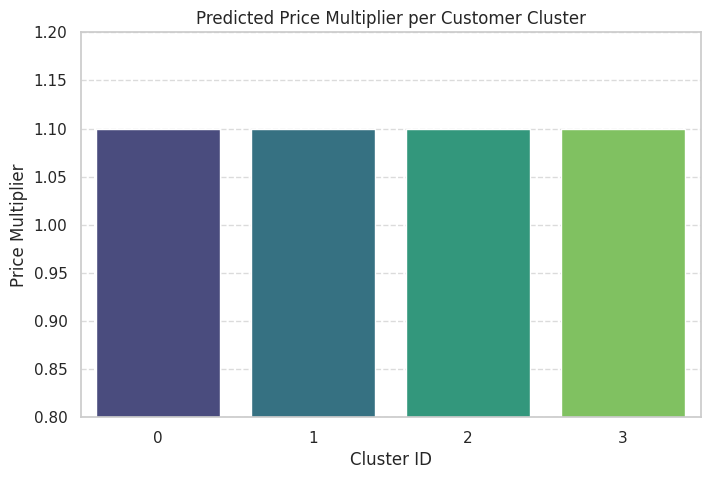

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [77]:
# Show price multiplier per cluster

cluster_multipliers = []

# Using fixed average values for price and demand to isolate cluster effect
fixed_price_normalized = 100 / 200  # Example: mid-range price
fixed_demand = 0.5                  # Example: mid-range demand

print("Predicting Price Multipliers for each cluster:")
for cluster_id in range(K_CLUSTERS):
    # Create a synthetic observation for each cluster
    # The observation space for PricingEnv is (price/200, demand, cluster/3, 0)
    obs = np.array([
        fixed_price_normalized,
        fixed_demand,
        cluster_id / (K_CLUSTERS - 1), # Normalize cluster_id to [0, 1]
        0.0 # Placeholder
    ], dtype=np.float32)

    action, _ = model.predict(obs, deterministic=True) # Use deterministic to get consistent prediction
    multiplier = env.mult[action]
    cluster_multipliers.append({'cluster': cluster_id, 'price_multiplier': multiplier})
    print(f"  Cluster {cluster_id}: Price Multiplier = {multiplier}")

multipliers_df = pd.DataFrame(cluster_multipliers)

print("\nSummary of Price Multipliers per Cluster:")
display(multipliers_df)

# Visualize the price multipliers
plt.figure(figsize=(8, 5))
sns.barplot(x='cluster', y='price_multiplier', data=multipliers_df, palette='viridis')
plt.title('Predicted Price Multiplier per Customer Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Price Multiplier')
plt.ylim(0.8, 1.2) # Set y-axis limits to clearly show differences between 0.9, 1.0, 1.1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
